In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import linear_model as linMod
import toolbox as tb;

We generate toydata

In [2]:
#toydata shall have n vectors with 5 dimensions
n = 100000
#probability for signal-label
s_prob = 0.05
dim = 4
data = tb.createToyData(n,dim,s_prob)
weights = data[:,0]
labels = data[:,1]
x_1 = data[:,2]
x_2 = data[:,3]

visualize

Populating the interactive namespace from numpy and matplotlib


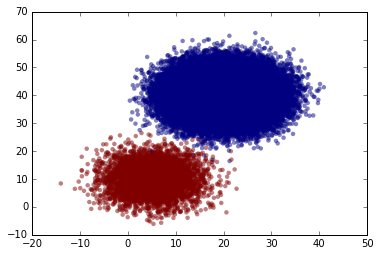

In [3]:
%pylab inline
plt.scatter(x_1, x_2, edgecolor="", c=labels, alpha=0.5)

split toydata into training- and testset for the classifier

In [4]:
n_train = int(n/10)

train_x_1,test_x_1 = tb.splitList(x_1,n_train)
train_x_2,test_x_2 = tb.splitList(x_2,n_train)
train_labels,test_labels = tb.splitList(labels,n_train)
test_weights = tb.splitList(weights,n_train)[1]

For Comparison, we calculate the best possible AMS    
(case: every signal correctly detected)

In [5]:
tb.calcMaxAMS(test_weights,test_labels);

Found 4474 signals.
Weightsums signal: 112.519230558 | background: 0
Maximum AMS possible with this Data: 19.721820983450662


we initialize the Logistic Regression Classifier, shape the input-data and fit the model

In [6]:
logReg = linMod.LogisticRegression(C=1e5)

train_x = np.array([train_x_1,train_x_2]).transpose()
test_x = np.array([test_x_1,test_x_2]).transpose()
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

logReg.fit(train_x,train_labels)

logReg.sparsify()

predProb = logReg.predict_proba(test_x)
pred = logReg.predict(test_x)
score = logReg.score(test_x,test_labels)

print("Score:", score)

Score: 0.999833333333


In [7]:
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

AMS: 18.392472651997792


We successfully tested logistic Regression, now let's use it on actual CERN-Data.           

In [8]:
import kaggleData as kD;

In [9]:
csvDict,header = kD.createCsvDictionary();

Trainingset has key "t"                   
Public Testset has key "b"   
Private Testset has key "v"

In [10]:
def getFeatureSets(featureName,testset = ["v"]):
    trainFeature = kD.getFeatureAsNpArray(
        csvDict,header,featureName,["t"],hasErrorValues = True)
    testFeature = kD.getFeatureAsNpArray(
        csvDict,header,featureName,testset,hasErrorValues = True)
    return trainFeature, testFeature

In [11]:
train_eventList,test_eventList = getFeatureSets("EventId")
train_labels,test_labels = getFeatureSets("Label")
test_weights = getFeatureSets("KaggleWeight")[1]

How are labels and weights related?

In [12]:
signal_sum = int(test_labels.cumsum()[-1])
background_sum = int(len(test_labels)-signal_sum)
signal_weight = 0
background_weight = 0
for i in range(0,len(test_labels)):
    if test_labels[i] > 0:
        signal_weight += test_weights[i]
    else:
        background_weight += test_weights[i]
print("Mean of background-weights:", background_weight/background_sum)
print("Mean of signal-weights:",signal_weight/signal_sum)

Mean of background-weights: 1.38702756616
Mean of signal-weights: 0.00450270106462


We observe that False signals are weighted a lot heavier than True signals. 

If a classifier achieved a higher AMS while detecting less signals,   
we can make statements about the usabilty of the features, the classifier used.

We choose features with beneficial properties for classifying.

In [13]:
(train_DER_met_phi_centrality,
 test_DER_met_phi_centrality) = getFeatureSets("DER_met_phi_centrality")
(train_DER_pt_ratio_lep_tau,
 test_DER_pt_ratio_lep_tau) = getFeatureSets("DER_pt_ratio_lep_tau")

Using DER_mass_MMC was not allowed in the former contest, we use it here anyway to test our classifier

In [14]:
(train_DER_mass_MMC,
 test_DER_mass_MMC) = getFeatureSets("DER_mass_MMC")

In [15]:
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

In [16]:
tb.calcMaxAMS(test_weights,test_labels);

Found 153683 signals.
Weightsums signal: 691.988607714 | background: 0
Maximum AMS possible with this Data: 67.71112289514173


We start with one feature and add more with every regression to see improvement of the AMS

In [17]:
def logisticReg(train_x,train_labels,test_x,test_labels):
    logReg = None
    logReg = linMod.LogisticRegression(C=1e5)
    logReg.fit(train_x,train_labels)
    logReg.sparsify()
    predProb = logReg.predict_proba(test_x)
    pred = logReg.predict(test_x)
    signals = int(pred.cumsum()[-1])  
    return predProb,pred,score

In [18]:
def logRegFor(fList):
    for feature in fList:
        print("Feature:",feature)
        trainList_x,testList_x = kD.getFeatureSets(feature)
        train_x = np.array([trainList_x]).transpose()
        test_x = np.array([testList_x]).transpose()
        logisticReg(train_x,train_labels,test_x,test_labels)[1];

In [19]:
(train_PRI_tau_pt,
 test_PRI_tau_pt) = getFeatureSets("PRI_tau_pt")
(train_DER_met_phi_centrality,
 test_DER_met_phi_centrality) = getFeatureSets("DER_met_phi_centrality")
(train_DER_pt_h,
 test_DER_pt_h) = getFeatureSets("DER_pt_h")
(train_DER_pt_ratio_lep_tau,
 test_DER_pt_ratio_lep_tau) = getFeatureSets("DER_pt_ratio_lep_tau")
(train_DER_mass_transverse_met_lep,
 test_DER_mass_transverse_met_lep) = getFeatureSets("DER_mass_transverse_met_lep")

We are able to achieve a higher AMS by adjusting the decision-threshold

In [20]:
def customThreshold(predProb,t = 0.5):
    newPred = np.zeros(len(predProb))
    for i in range(0,len(predProb)):
        if predProb[i][1] > t:
            newPred[i]=1
    return newPred   

In [21]:
def bestThreshold(predProb):
    bestPred = predProb
    thresh = 0
    maxAMS = 0
    maxThresh = 0
    newSignals = 0
    for thresh in np.linspace(1.0,0.0,100):
        newPred = customThreshold(predProb,thresh)
        s,b = tb.calcWeightSums(test_weights,newPred,test_labels)
        #print("s:",s,"b:",b)
        ams = tb.calcAMS(s,b)
        #print("ams:",ams)
        if ams > maxAMS:
            bestPred = newPred
            maxThresh = thresh
            maxAMS = ams
            newSignals = int(newPred.cumsum()[-1])
    #print("Maximum AMS:",maxAMS, "with threshold", maxThresh)
    #print("Signals read:", newSignals)
    return bestPred,maxAMS,maxThresh,newSignals

In [22]:
def compareBinaryArrays(a,b):
    if shape(a) != shape(b):
        print("ERROR: Arrays must have same shape.")
        return None
    eq_total = 0
    eq_ones = 0
    eq_zeros = 0
    for i in range(0,len(a)):
        if a[i] == b[i]:
            eq_total += 1
            if a[i] == 1:
                eq_ones += 1
            else:
                eq_zeros += 1
    return eq_total,eq_ones,eq_zeros

In [23]:
def fullEvaluation(predProb,pred,test_weights,test_labels):
    signals = pred.cumsum()[-1]
    correct = np.equal(pred,test_labels).cumsum()[-1]    
    s,b = tb.calcWeightSums(test_weights,pred,test_labels)
    ams = tb.calcAMS(s,b)
   
    newPred,maxAMS,maxThresh,newSignals = bestThreshold(predProb)
    newcorrect = np.equal(newPred,test_labels).cumsum()[-1]
    
    T_eq1,T_eq0 = compareBinaryArrays(test_labels,test_labels)[1:]
    o_eqt,o_eq1,o_eq0 = compareBinaryArrays(pred,test_labels)
    a_eqt,a_eq1,a_eq0 = compareBinaryArrays(newPred,test_labels)
    
    print("Signals in test-data:", test_labels.cumsum()[-1])
    print("Comparison of [o]riginal and [a]djusted predictions:\n"+
          " - [o]Signals read:", signals,"\n"+
          " - [a]Signals read:", newSignals,"\n"+
          " -- Difference:", (signals-newSignals),"\n"+
          " - [o]Correct labels:", o_eqt,"| signals:", o_eq1,"| background:",o_eq0,"\n"+
          " ----- wrong signals:", (T_eq1-o_eq1), "| background:", (T_eq0-o_eq0),"\n"+
          " - [a]Correct labels:", a_eqt,"| signals:", a_eq1,"| background:",a_eq0,"\n"+
          " ----- wrong signals:", (T_eq1-a_eq1), "| background:", (T_eq0-a_eq0),"\n"+
          " -- Difference labels:", (a_eqt-o_eqt),"| signals:", (a_eq1-o_eq1),"| background:",(a_eq0-o_eq0),"\n"+
          " - [o]AMS:", ams,"\n"+
          " - [a]AMS:", maxAMS,"(threshold =",maxThresh,")\n"+
          " -- Difference:", (ams-maxAMS),"\n"
         )
    return pred,newPred

In [24]:
train_x = np.array(
    [train_PRI_tau_pt,
     train_DER_met_phi_centrality,
     train_DER_pt_h,
     train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array(
    [test_PRI_tau_pt,
     test_DER_met_phi_centrality,
     test_DER_pt_h,
     test_DER_pt_ratio_lep_tau]).transpose()
(predProb,
 pred) = logisticReg(
    train_x,
    train_labels,
    test_x,
    test_labels)[0:2];
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 88314.0 
 - [a]Signals read: 270377 
 -- Difference: -182063.0 
 - [o]Correct labels: 315491 | signals: 53744 | background: 261747 
 ----- wrong signals: 99939 | background: 34570 
 - [a]Correct labels: 275182 | signals: 124621 | background: 150561 
 ----- wrong signals: 29062 | background: 145756 
 -- Difference labels: -40309 | signals: 70877 | background: -111186 
 - [o]AMS: 1.3192322666968355 
 - [a]AMS: 1.4167498277657031 (threshold = 0.252525252525 )
 -- Difference: -0.09751756106886766 



In [25]:
print("[o] correct signal/correct labels:",(53744/315491))
print("[o] correct background/correct labels:",(261747/315491))
print("[a] correct signal/correct labels:",(124621/275182))
print("[a] correct background/correct labels:",(150561/275182))
print("")
print("[o] wrong signal/wrong labels:",(99939/(len(test_labels)-315491)))
print("[o] wrong background/wrong labels:",(34570/(len(test_labels)-315491)))
print("[a] wrong signal/wrong labels:",(29062/(len(test_labels)-275182)))
print("[a] wrong background/wrong labels:",(145756/(len(test_labels)-275182)))

[o] correct signal/correct labels: 0.17035034279900219
[o] correct background/correct labels: 0.8296496572009978
[a] correct signal/correct labels: 0.4528675567442638
[a] correct background/correct labels: 0.5471324432557362

[o] wrong signal/wrong labels: 0.7429911753116892
[o] wrong background/wrong labels: 0.2570088246883108
[a] wrong signal/wrong labels: 0.16624146254962305
[a] wrong background/wrong labels: 0.833758537450377


By adjusting the threshold, we raise the rate of correct signals at the expense of correctly predicted background-events.
This results in a higher AMS even though we softened our decision-threshold

In [26]:
train_x = np.array(
    [train_PRI_tau_pt,
     train_DER_met_phi_centrality]).transpose()
test_x = np.array(
    [test_PRI_tau_pt,
     test_DER_met_phi_centrality]).transpose()
predProb,pred = logisticReg(
    train_x,
    train_labels,
    test_x,
    test_labels)[0:2];
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 70612.0 
 - [a]Signals read: 299182 
 -- Difference: -228570.0 
 - [o]Correct labels: 313525 | signals: 43910 | background: 269615 
 ----- wrong signals: 109773 | background: 26702 
 - [a]Correct labels: 259123 | signals: 130994 | background: 128129 
 ----- wrong signals: 22689 | background: 168188 
 -- Difference labels: -54402 | signals: 87084 | background: -141486 
 - [o]AMS: 1.1512119152385953 
 - [a]AMS: 1.3397092760005813 (threshold = 0.222222222222 )
 -- Difference: -0.18849736076198598 



In [27]:
train_x = np.array(
    [train_DER_met_phi_centrality,
     train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array(
    [test_DER_met_phi_centrality,
     test_DER_pt_ratio_lep_tau]).transpose()
predProb,pred = logisticReg(
    train_x,train_labels,
    test_x,
    test_labels)[0:2];
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 105546.0 
 - [a]Signals read: 266339 
 -- Difference: -160793.0 
 - [o]Correct labels: 311453 | signals: 60341 | background: 251112 
 ----- wrong signals: 93342 | background: 45205 
 - [a]Correct labels: 273910 | signals: 121966 | background: 151944 
 ----- wrong signals: 31717 | background: 144373 
 -- Difference labels: -37543 | signals: 61625 | background: -99168 
 - [o]AMS: 1.3069521546244742 
 - [a]AMS: 1.4054130567873595 (threshold = 0.262626262626 )
 -- Difference: -0.09846090216288528 

